In [32]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook

from mhrw import MHRWSampler
from mhrw.utils import start_session

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def degree_cdf(graph_neigh, k_range):
    degree_dist = np.zeros_like(k_range)
    count = graph_neigh.count()
    
    for i, k in enumerate(tqdm_notebook(k_range)):
        degree_k = graph_neigh.filter(f"degree <= {k}").count()
        degree_dist[i] = degree_k
    
    return degree_dist / count

def process_fb(path, save_path=None, to_undirected=False, compression="UNCOMPRESSED"):
    get_edges = lambda row: row.split()[:2]
    head = lambda itr, i: [next(itr) for _ in range(i)]
    
    with open(path, "r") as file:
        edge_list = map(get_edges, file)
        header = head(edge_list, 2)

        df = pd.DataFrame(edge_list, columns=["user", "item"]).drop_duplicates()
        df = df.astype({"user": "int64", "item": "int64"})
        
        if to_undirected:
            df_inv = df.rename(columns={"user": "item", "item": "user"})
            df = df.append(df_inv)
        
        if save_path:
            df.to_parquet("data/fb_edge_list", index=False, compression=compression)
    
    return df

# Network data

[Facebook friendship graph](http://networkrepository.com/fb-wosn-friends.php) where nodes are users and edges between the users represent friendship relations/edges. 

In [29]:
%%time
df = process_fb("data/fb-wosn-friends.edges", "data/fb_edge_list")

CPU times: user 4.93 s, sys: 557 ms, total: 5.49 s
Wall time: 7.24 s


# Sampling

In [23]:
spark, sc = start_session("test_sample")

import pyspark.sql.functions as F

In [24]:
graph = spark.read.parquet("data/fb_edge_list")

In [27]:
sampler = MHRWSampler(spark, ids_path="tmp",seed_ratio=0.08, method="RCMH", alpha=0.3)

In [36]:
sampler.fit(graph)

INFO - 2019-09-16 22:27:11: sampled 3565 seed nodes, budget: 4509
INFO - 2019-09-16 22:27:29: iteration 1, sampled 6027 nodes, progress: 133.67%
INFO - 2019-09-16 22:27:29: the budget has been spent! stop sampling


In [53]:
sampled_graph = sampler.transform(graph)

In [54]:
print(f"full graph: {graph.count()} edges")
print(f"sampled graph: {sampled_graph.count()} edges")

full graph: 817090 edges
sampled graph: 15808 edges


# Node Degree Distribution 

In [52]:
def get_neigs(df):
    return (df
            .groupBy("user")
            .agg(F.collect_list("item").alias("neigh"))
            .withColumn("degree", arr_len("neigh")))

In [47]:
from mhrw.utils import arr_len
from mhrw.utils import graph_filter_ids

In [48]:
k_range = np.arange(1, 80, 2.5)

In [55]:
graph_neig = get_neigs(graph)
graph_random = graph_neig.sample(False, 0.1, seed=42)
graph_mhrw = get_neigs(sampled_graph)

In [56]:
base_ndd = degree_cdf(graph_neig, k_range)
random_ndd = degree_cdf(graph_random, k_range)
mhrw_ndd = degree_cdf(graph_mhrw, k_range)

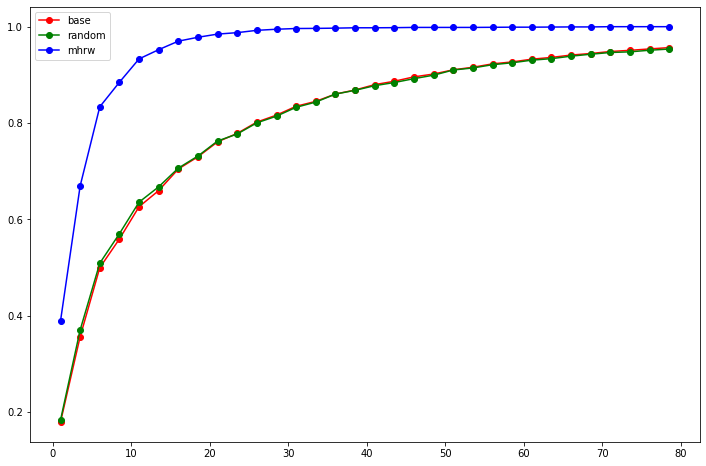

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(k_range, base_ndd, marker='o', color="red", label="base");
plt.plot(k_range, random_ndd, marker='o', color="green", label="random");
plt.plot(k_range, mhrw_ndd, marker='o', color="blue", label="mhrw");
plt.legend();

In [58]:
sampler.clear_ids()

'tmp'